<a href="https://colab.research.google.com/github/painterV/some_coding/blob/main/bipartite_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#导入networkx包重命名为nx
# !pip3 uninstall scipy
# !pip3 install 'scipy<1.8'
# !pip3 uninstall networkx
# !pip3 install 'networkx<2.7'
import networkx as nx
#从networkx.algorithms里导入bipartite
from networkx.algorithms import bipartite

# 定义一个列表，存储 Physicians 类型的结点
Physicians = ['A', 'B', 'C', 'D', 'E', 'F']
# 定义一个列表，存储 Patients 类型的结点
Patients = [1,2,3]

#定义一个列表，内部元素为元组，表示 Physicians结点到 Patients结点的连接关系（边）
edges = [('A', 1), ('A', 2), ('B', 1), ('C', 1), ('C', 2), ('D', 2), ('D', 3), ('E', 2), ('E', 3), ('F', 3)]

def CreateBipartiteGraph(nodes1, nodes2, edges):
    '''定义一个函数
    传入参数：
        nodes1:第一个类型的节点列表, List类型
        nodes2:第二个类型的节点列表, List类型
        edges: 边集合列表, List类型
    返回值：一个图 networkx.Graph 类型
    '''
    # 新建一个空的图
    B = nx.Graph()
    # 添加 Physicians 类型的结点到图中，注意要设置图的属性值 bipartite=0
    B.add_nodes_from(nodes1, bipartite=0)
    # 添加 patients 类型的结点到图中，注意要设置图的属性值 bipartite=1
    B.add_nodes_from(nodes2, bipartite=1)
    # 添加边
    B.add_edges_from(edges)

    #for循环为每一条边初始化权重为1
    for v, w in B.edges: 
        B.edges[v, w]["weight"] = 1
    return B

#创建目标二部图
B = CreateBipartiteGraph(Physicians, Patients, edges)

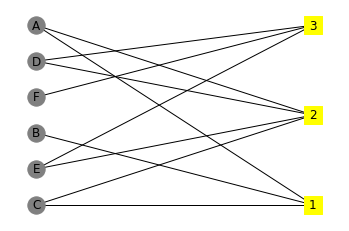

In [3]:
#导入画图的库pyplot
import matplotlib.pyplot as plt
# top = nx.bipartite.sets(B)[0]
# bottom = nx.bipartite.sets(B)[1]
# print(top)
# print(bottom)

#设置二部图的布局，其中B是上述已定义的二部图，top是指定 Physicians类型的节点在左边或者上边, 也可以换成 Patients
pos = nx.bipartite_layout(B, nodes=Physicians)
#画图的 Physicians类型节点，设置node颜色是灰色，形状是圆圈
nx.draw_networkx_nodes(B, pos=pos, nodelist=Physicians, node_color='grey', node_shape='o')
#画图的 Patients 类型节点，设置node颜色是黄色，形状是square(正方形)
nx.draw_networkx_nodes(B, pos=pos, nodelist=Patients, node_color='yellow', node_shape='s')
# 画图的点的labels （A,B,C,D,E,F) (1,2,3)
nx.draw_networkx_labels(B, pos)
#画图的边
nx.draw_networkx_edges(B, pos)
#关闭axis
plt.axis('off')
#将图展示在屏幕上
plt.show()

In [4]:
def plotGraph(G):
    pos = nx.spring_layout(G)  # positions for all nodes - seed for reproducibility
    # nodes，先可视化点
    nx.draw_networkx_nodes(G, pos)
    # edges，可视化边
    nx.draw_networkx_edges(G, pos)
    # node labels，可视化标签
    nx.draw_networkx_labels(G, pos)
    # edge weight labels，可视化边的权重标签
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    print("单图投射可视化：")
    plt.axis("off")
    plt.show()

Physicians 矩阵计算的方式进行单图投射：
单图投射可视化：


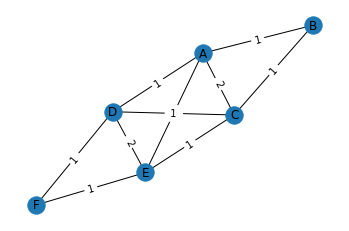

Patients 矩阵计算的方式进行单图投射：
单图投射可视化：


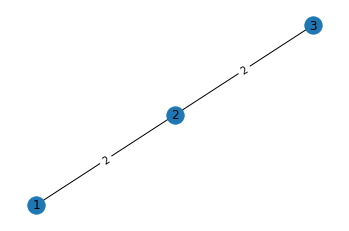

In [5]:
##导入矩阵计算相关的包
import numpy as np
from scipy import sparse

#通过邻接矩阵计算的方式获取单图投射
def GetProjectionByMatrix(B, nodes):
    #获取二部图的邻接矩阵，并转为dense矩阵
    A = bipartite.biadjacency_matrix(B, nodes).todense()
    # print(A)
    # print(type(A))
    #获取邻接矩阵的转置矩阵
    AT = A.transpose()
    # print(type(AT))
    # print(AT)

    # print(A.toarray())
    #计算 邻接矩阵与其转置矩阵的乘积
    A_AT = np.dot(A, AT)
    # print(A_AT)
    #将上述邻接矩阵结果(np array)转为压缩稀疏矩阵，再转为dense矩阵用于下面遍历其元素
    sA = sparse.csr_matrix(A_AT).todense()

    #新建一个空白图
    tG = nx.Graph()

    #获取 计算得到的矩阵的大小 行和列数
    [rows, cols] = sA.shape
    edges = []
    #遍历矩阵，将矩阵的右上角的元素作为边及权重添加到图tG的边中。
    #注意判断条件 i > j 是选择右上角（因为图是无向图，所以只需要关注邻接矩阵的一半即可）
    #另外要注意 这里我们把矩阵元素值作为权重加到边的标签上，但要注意过滤掉权重为0的，表示这条边不存在，不需要加入图
    for i in range(rows):
        for j in range(cols):
            if i > j and sA[i, j] > 0:
                edges.append((nodes[i], nodes[j], {"weight": sA[i, j]}))
    
    #添加点到图中
    tG.add_nodes_from(nodes)
    #添加边到图中
    tG.add_edges_from(edges)
    #画图
    plotGraph(tG)

print("Physicians 矩阵计算的方式进行单图投射：")
GetProjectionByMatrix(B, Physicians)

print("Patients 矩阵计算的方式进行单图投射：")
GetProjectionByMatrix(B, Patients)

In [8]:


##定义一个函数 GetProjectionAndTopKPrNodes
def GetProjectionAndTopKPrNodes(B, nodes, k):

    #######Step1: 二部图投射到单类型结点
    G = bipartite.weighted_projected_graph(B, nodes)
    print("单图投射:")
    print(G)
    A = nx.to_numpy_array(G)
    print("单图投射的邻接矩阵为：")
    print(A)

    #######Step2: 投射图的可视化
    plotGraph(G)

    #######Step3: 计算PR值，并打印top k的结点
    #计算pr值
    pr_dic = nx.pagerank(G)
    #对各结点根据pr值由大到小排序
    s = sorted(pr_dic.items(), key=lambda x: x[1], reverse=True)
    #输出pr值top k的结点
    print("pr top ", k , "nodes", [item[0] for item in s[:k]])



#######Physicians 通过bipartite包单图投射
单图投射:
Graph with 6 nodes and 10 edges
单图投射的邻接矩阵为：
[[0. 1. 2. 1. 1. 0.]
 [1. 0. 1. 0. 0. 0.]
 [2. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 2. 1.]
 [1. 0. 1. 2. 0. 1.]
 [0. 0. 0. 1. 1. 0.]]
单图投射可视化：


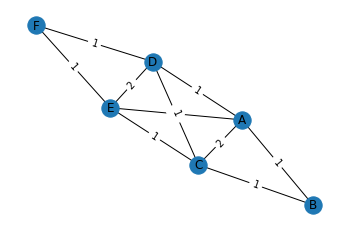

pr top  5 nodes ['A', 'C', 'D', 'E', 'F']
#######Physicians 通过bipartite包单图投射
单图投射:
Graph with 3 nodes and 2 edges
单图投射的邻接矩阵为：
[[0. 2. 0.]
 [2. 0. 2.]
 [0. 2. 0.]]
单图投射可视化：


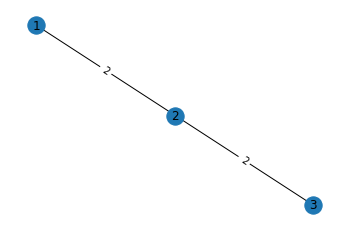

pr top  1 nodes [2]


In [9]:
print("#######Physicians 通过bipartite包单图投射")
GetProjectionAndTopKPrNodes(B, Physicians, 5)

print("#######Physicians 通过bipartite包单图投射")
GetProjectionAndTopKPrNodes(B, Patients, 1)